In [23]:
import pandas as pd
import numpy as np
import matplotlib

ModuleNotFoundError: No module named 'matplotlib'

In [24]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 9.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.4 MB/s eta 0:00:00a 0:00:01


In [8]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [10]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Calculate percentage changes
btc['PctChange'] = btc['Close'].pct_change()

# Cap percentage changes at ±3%
btc['CappedPctChange'] = btc['PctChange'].clip(lower=-0.03, upper=0.03)

# Calculate capped price changes
btc['CappedPriceChange'] = btc['CappedPctChange'] * btc['Close'].shift(1)

# Separate gains and losses
btc['Gain'] = btc['CappedPriceChange'].where(btc['CappedPriceChange'] > 0, 0)
btc['Loss'] = -btc['CappedPriceChange'].where(btc['CappedPriceChange'] < 0, 0)

# Calculate average gains and losses (using a 26-period window)
window = 13
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

# Set first few RSI values to NaN due to instability
btc.loc[btc.index[:window-1], 'RSI'] = np.nan


In [11]:
btc['MA200'] = btc['Close'].rolling(window=200).mean()
btc['MA20'] = btc['Close'].rolling(window=20).mean()
btc['MA50'] = btc['Close'].rolling(window=50).mean()

In [12]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

In [13]:

btc['EMA_6'] = btc['Close'].rolling(window=12).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

btc['Signal'] = btc['MACD'].ewm(span=9, adjust=False).mean()

In [14]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
btc['STD15'] = btc['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
btc['BB_Upper'] = btc['SMAVG (15)  on Close'] + (btc['STD15'] * 2)
btc['BB_Lower'] = btc['SMAVG (15)  on Close'] - (btc['STD15'] * 2)

# Calculate Bollinger Band Width
btc['BB_Width'] = (btc['BB_Upper'] - btc['BB_Lower']) / btc['SMAVG (15)  on Close']

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()

In [15]:
# Create lagged columns (shift by 1)
lagged_btc = btc.copy()
for col in btc.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_btc[col + '_lag1'] = btc[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_btc = lagged_btc[['Date', 'Close', 'Open'] + [col + '_lag1' for col in btc.columns if col not in ['Date', 'Close']]]

lagged_btc.drop(index=lagged_btc.index[:30], inplace=True)

# Display result
lagged_btc.head()

,Date,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,SMAVG (15) on Close_lag1,PriceChange_lag1,...,%K_lag1,%D_lag1,EMA_6_lag1,EMA_12_lag1,MACD_lag1,Signal_lag1,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1
30,2024-01-01 15:00:00,42488.50,42401.07,42319.73,42425.06,42309.16,42328.36,42381.63,42403.86,81.34,...,37.448507,22.399840,42408.357500,42453.842692,-45.485192,-59.692875,137.085569,42678.031139,42129.688861,0.012931
31,2024-01-01 15:30:00,42490.34,42488.50,42401.07,42495.70,42401.07,42348.20,42376.89,42417.77,87.43,...,53.384857,37.818526,42408.727500,42448.977308,-40.249808,-55.804261,136.294097,42690.358194,42145.181806,0.012853
32,2024-01-01 16:00:00,42483.53,42490.34,42488.50,42500.88,42441.13,42386.88,42368.57,42422.96,1.84,...,68.879125,53.237496,42399.596667,42443.141538,-43.544872,-53.352383,134.507948,42691.975896,42153.944104,0.012683
33,2024-01-01 16:30:00,42550.10,42483.53,42490.34,42534.45,42461.38,42436.63,42373.88,42424.18,-6.81,...,71.551767,64.605250,42395.234167,42436.596154,-41.361987,-50.954304,134.382552,42692.945103,42155.414897,0.012670
34,2024-01-01 17:00:00,42590.30,42550.10,42483.53,42552.55,42463.72,42482.71,42395.88,42428.58,66.57,...,91.739130,77.390007,42393.275833,42434.720000,-41.444167,-49.052277,132.914844,42694.409688,42162.750312,0.012531


In [16]:
lagged_btc = lagged_btc[(lagged_btc['Date'] >= '2025-01-01') & (lagged_btc['Date'] < '2025-03-01')]

In [17]:
btc = pd.read_csv("../data/btc_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])
df_btc

,Unnamed: 0,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,BTC_BreakHigh2_lag1
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False
...,...,...,...,...,...,...
2827,20366,2025-02-28 21:30:00,81465.09,82093.36098,80695.28,True
2828,20367,2025-02-28 22:00:00,81785.98,82832.43628,81465.09,True
2829,20368,2025-02-28 22:30:00,82054.27,82792.20484,81785.98,True
2830,20369,2025-02-28 23:00:00,84317.02,83402.23912,82054.27,True


In [18]:
merged = df_btc.merge(lagged_btc, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'BTC_BreakHigh2_lag1'])

In [20]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged.copy().reset_index(drop=True)

# Calculate price change predictions
trading_results2['Actual_Diff'] = trading_results2['BTC_Actual'] / trading_results2['Open'] - 1

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0
stop_loss_pct = 0.05  # 5% stop-loss

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'BTC_Actual']
    current_open = trading_results2.at[i, 'Open']
    prev_ma200 = trading_results2.at[i, 'MA200_lag1']
    prev_ma20 = trading_results2.at[i, 'MA20_lag1']
    prev_ma50 = trading_results2.at[i, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']
    prev_rsi = trading_results2.at[i, 'RSI_lag1']

    if trading_results2.at[i, 'Actual_Diff'] > 0.003 and current_open <= lowerbb and prev_ma50 > prev_ma200: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Actual_Diff'] < -0.0015 and current_open >= upperbb and prev_ma50 < prev_ma200:
        trading_results2.at[i, 'Signal'] = -1

    current_price = trading_results2['BTC_Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 5000:  # Buy
        buy_amount = cash - 5000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Implement stop-loss: if price falls 5% below entry price, sell
    if position > 0 and current_price <= entry_price * (1 - stop_loss_pct):
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Stop-Loss Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

Total Return: 5.29%
Number of Trades: 6
Maximum Drawdown: 7.40%
Final Portfolio Value: 210,584.70


/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/3535931186.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9824779449328627' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/3535931186.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4902.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Cash'] = cash
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/3535931186.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '98361.75' has dtype incompatible with int64, please explicitly cast to a c

In [21]:
trading_results2[trading_results2['Signal'] != 0]

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Actual_Diff,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
48,2025-01-02 00:00:00,93936.14,94216.92898,94217.34,94217.34,93969.42,94284.41,93902.34,93942.42,93715.32,...,94081.710587,92979.889413,0.011780,-0.002985,-1,0.000000,200000.000000,0.00,200000.000000,Hold
484,2025-01-11 02:00:00,94993.12,95620.24292,95775.25,95773.92,94341.72,95799.47,94058.72,94182.21,94097.27,...,95665.938728,93122.581272,0.026944,-0.008153,-1,0.000000,200000.000000,0.00,200000.000000,Hold
540,2025-01-12 06:00:00,94697.36,94802.58538,94898.25,94908.38,94769.75,94981.23,94620.88,94564.28,94367.38,...,94786.834509,93994.485491,0.008394,-0.002223,-1,0.000000,200000.000000,0.00,200000.000000,Hold
766,2025-01-16 23:00:00,98361.75,97901.51202,97572.94,97572.94,99324.62,99337.69,97468.44,98834.53,99006.98,...,100086.721527,98094.798473,0.020102,0.008084,1,1.982478,4902.500000,98361.75,199902.500000,Buy
924,2025-01-20 06:00:00,104069.55,103333.58240,103565.03,103556.28,104307.00,105146.23,103565.03,105183.12,105031.24,...,106086.679571,103889.680429,0.020926,0.004956,1,1.982478,4902.500000,98361.75,211218.087614,Hold
927,2025-01-20 07:30:00,101206.47,100962.48236,100393.83,100400.69,103326.50,103326.50,100257.53,103132.38,104369.82,...,106547.764391,102508.515609,0.038643,0.008026,1,1.982478,4902.500000,98361.75,205542.094660,Hold
930,2025-01-20 09:00:00,100152.53,99610.50900,99725.00,99725.00,100983.91,101124.88,99488.17,101127.34,102955.64,...,106876.894393,100533.425607,0.061168,0.004287,1,1.982478,4902.500000,98361.75,203452.681854,Hold
1052,2025-01-22 22:00:00,104642.42,104014.64962,104061.30,104061.30,104877.27,104912.52,103822.06,104935.23,104950.95,...,105954.649553,104111.870447,0.017545,0.005584,1,1.982478,4902.500000,98361.75,212353.789754,Hold
1102,2025-01-23 23:00:00,104232.64,104392.55140,105166.94,105166.94,102382.22,106024.97,102319.31,102620.04,102224.73,...,103705.142386,100730.877614,0.029097,-0.008884,-1,0.000000,211438.090487,0.00,211438.090487,Sell
1105,2025-01-24 00:30:00,105168.50,105707.04602,106007.38,106007.38,105259.44,106850.25,105114.94,104610.08,103218.01,...,105028.449546,100520.590454,0.043862,-0.007913,-1,0.000000,211438.090487,0.00,211438.090487,Hold


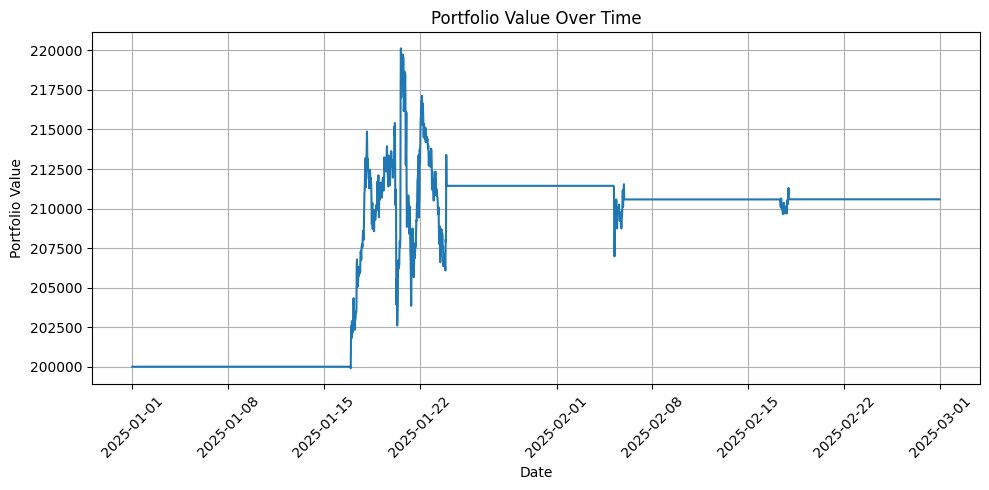

In [25]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results2['Date'], trading_results2['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

## Predicted returns 

In [27]:
btc_returns = pd.read_csv("../data/btc_rf_predictions_rolling_returns.csv")

btc_returns = btc_returns.drop(columns=['Unnamed: 0'])

btc_returns["Date"] = pd.to_datetime(btc_returns["Date"])
btc_returns

,Date,Actual,Predicted
0,2025-01-01 00:00:00,-0.004864,-0.001040
1,2025-01-01 00:30:00,-0.001385,-0.001856
2,2025-01-01 01:00:00,-0.003476,-0.000240
3,2025-01-01 01:30:00,-0.004209,-0.000777
4,2025-01-01 02:00:00,-0.001337,-0.000166
...,...,...,...
2827,2025-02-28 21:30:00,0.009540,-0.001567
2828,2025-02-28 22:00:00,0.003939,-0.001637
2829,2025-02-28 22:30:00,0.003280,-0.000904
2830,2025-02-28 23:00:00,0.027576,-0.000064


In [28]:
btc_returns['Product'] = btc_returns['Actual'] * btc_returns['Predicted']
btc_returns[btc_returns['Product'] >= 0]  # Filter based on the product


,Date,Actual,Predicted,Product
0,2025-01-01 00:00:00,-0.004864,-0.001040,5.056906e-06
1,2025-01-01 00:30:00,-0.001385,-0.001856,2.569508e-06
2,2025-01-01 01:00:00,-0.003476,-0.000240,8.345284e-07
3,2025-01-01 01:30:00,-0.004209,-0.000777,3.271842e-06
4,2025-01-01 02:00:00,-0.001337,-0.000166,2.212552e-07
...,...,...,...,...
2815,2025-02-28 15:30:00,-0.003815,-0.000029,1.087680e-07
2816,2025-02-28 16:00:00,-0.004396,-0.000859,3.776906e-06
2819,2025-02-28 17:30:00,-0.000728,-0.003502,2.548288e-06
2823,2025-02-28 19:30:00,-0.001110,-0.000632,7.010971e-07


In [29]:
merged_returns = btc_returns.merge(lagged_btc, on = 'Date', how = 'left')

In [30]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged_returns.copy().reset_index(drop=True)

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'Close']
    current_open = trading_results2.at[i, 'Open']
    prev_ma200 = trading_results2.at[i, 'MA200_lag1']
    prev_ma20 = trading_results2.at[i, 'MA20_lag1']
    prev_ma50 = trading_results2.at[i, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']
    prev_rsi = trading_results2.at[i, 'RSI_lag1']
    prev_k = trading_results2.at[i, '%K_lag1']
    prev_d = trading_results2.at[i, '%D_lag1']
    prev_macd = trading_results2.at[i, 'MACD_lag1']
    prev_signal = trading_results2.at[i, 'Signal_lag1']
    # prev_ma5 = trading_results2.at[i-1, 'SMAVG (5) on Close_lag1']
    # prev_ma10 = trading_results2.at[i-1, 'SMAVG (10) on Close_lag1']

    if trading_results2.at[i, 'Predicted'] > 0 and current_open <= lowerbb and prev_ma20 < prev_ma50 and prev_macd < 0 and prev_macd < 0 and prev_macd >= prev_signal: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted'] < 0 and current_open >= upperbb and prev_ma20 > prev_ma50:
        trading_results2.at[i, 'Signal'] = -1
    '''
    if trading_results2.at[i, 'Predicted'] > 0 and current_open <= lowerbb and prev_ma20 < prev_ma50 and prev_macd < 0 and prev_macd > 0 and prev_macd >= prev_signal: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted'] < 0 and current_open >= upperbb and prev_ma20 < prev_ma50 and prev_rsi >= 70:
        trading_results2.at[i, 'Signal'] = -1
    '''
    # prev_rsi >= 70
    current_price = trading_results2['Close'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 5000:  # Buy
        buy_amount = cash - 5000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/900095748.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.042600689477244' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/900095748.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4902.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Cash'] = cash
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/900095748.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '95466.53' has dtype incompatible with int64, please explicitly cast to a compa

Total Return: 6.83%
Number of Trades: 6
Maximum Drawdown: 5.36%
Final Portfolio Value: 213,658.09


In [31]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged_returns.copy().reset_index(drop=True)

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'Close']
    current_open = trading_results2.at[i, 'Open']
    prev_ma200 = trading_results2.at[i, 'MA200_lag1']
    prev_ma20 = trading_results2.at[i, 'MA20_lag1']
    prev_ma50 = trading_results2.at[i, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']
    prev_rsi = trading_results2.at[i, 'RSI_lag1']
    prev_k = trading_results2.at[i, '%K_lag1']
    prev_d = trading_results2.at[i, '%D_lag1']
    prev_macd = trading_results2.at[i, 'MACD_lag1']
    prev_signal = trading_results2.at[i, 'Signal_lag1']
    # prev_ma5 = trading_results2.at[i-1, 'SMAVG (5) on Close_lag1']
    # prev_ma10 = trading_results2.at[i-1, 'SMAVG (10) on Close_lag1']

    if trading_results2.at[i, 'Predicted'] > 0 and current_open <= lowerbb and prev_macd < 0 and prev_signal < 0 and prev_macd > prev_signal: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted'] < 0 and current_open >= upperbb and prev_ma20 > prev_ma50 and prev_rsi >= 70:
        trading_results2.at[i, 'Signal'] = -1
    '''
    if trading_results2.at[i, 'Predicted'] > 0 and current_open <= lowerbb and prev_ma20 < prev_ma50 and prev_macd < 0 and prev_macd < 0 and prev_macd >= prev_signal: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted'] < 0 and current_open >= upperbb and prev_ma20 < prev_ma50 and prev_rsi >= 70:
        trading_results2.at[i, 'Signal'] = -1
    '''
    # prev_rsi >= 70
    current_price = trading_results2['Close'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 5000:  # Buy
        buy_amount = cash - 5000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/2758125445.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.042600689477244' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/2758125445.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4902.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Cash'] = cash
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_19252/2758125445.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '95466.53' has dtype incompatible with int64, please explicitly cast to a co

Total Return: 6.57%
Number of Trades: 4
Maximum Drawdown: 5.36%
Final Portfolio Value: 213,148.82


In [386]:
trading_results2.to_csv('../data/temp.csv')

In [452]:
trading_results2[trading_results2['Signal'] != 0]

,Date,Actual,Predicted,Product,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,...,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
366,2025-01-08 15:00:00,0.002054,0.001825,3.747227e-06,95466.53,95271.05,96177.22,96184.59,95267.84,96157.03,...,498.599138,97612.338275,95617.941725,0.020643,1,2.042601,4902.500000,95466.53,199902.500000,Buy
367,2025-01-08 15:30:00,0.001637,0.001609,2.633851e-06,95622.81,95466.53,95271.05,95677.48,95249.17,95999.12,...,505.472389,97527.484778,95505.595222,0.020949,1,2.042601,4902.500000,95466.53,200221.717636,Hold
441,2025-01-10 04:30:00,0.006634,0.002708,1.796646e-05,91883.56,91278.06,91914.97,92346.31,91207.20,92362.66,...,748.814367,94448.098734,91452.841266,0.032224,1,2.042601,4902.500000,95466.53,192583.923008,Hold
719,2025-01-15 23:30:00,-0.007293,-0.000575,4.191094e-06,98991.44,99718.67,99451.03,99776.25,99160.42,98813.41,...,803.941029,99149.582058,95933.817942,0.032968,-1,0.000000,207001.383605,0.00,207001.383605,Sell
817,2025-01-18 00:30:00,0.003814,-0.001333,-5.082414e-06,105029.69,104630.61,104037.30,104795.41,103880.39,103747.73,...,918.819968,104626.649935,100951.370065,0.035756,-1,0.000000,207001.383605,0.00,207001.383605,Hold
1820,2025-02-07 22:00:00,0.008679,-0.000158,-1.374326e-06,99697.81,98839.94,97725.30,98882.34,97277.50,98009.52,...,495.917459,98429.084918,96445.415082,0.020358,-1,0.000000,207001.383605,0.00,207001.383605,Hold
1932,2025-02-10 06:00:00,0.005378,0.001221,6.565998e-06,95772.91,95224.75,95976.25,95995.75,94759.48,96037.74,...,442.085995,97091.081991,95322.738009,0.018381,1,2.109170,4898.999308,95772.91,206900.382913,Buy
2271,2025-02-17 07:30:00,-0.001341,0.000326,-4.372093e-07,96134.81,96263.88,96907.75,96923.41,96201.66,96849.41,...,211.939140,97370.588280,96522.831720,0.008745,1,2.109170,4898.999308,95772.91,207663.691668,Hold
2486,2025-02-21 19:00:00,0.001471,-0.000289,-4.244879e-07,98784.81,98639.75,98447.72,98692.17,98439.59,98420.70,...,134.096766,98610.823532,98074.436468,0.005454,-1,0.000000,213148.816140,0.00,213148.816140,Sell
2487,2025-02-21 19:30:00,-0.001255,-0.000110,1.375386e-07,98660.84,98784.81,98639.75,98803.05,98523.08,98529.08,...,147.472714,98678.235428,98088.344572,0.005996,-1,0.000000,213148.816140,0.00,213148.816140,Hold


In [374]:
trading_results2

,Date,Actual,Predicted,Product,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,...,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
0,2025-01-01 00:00:00,-0.004864,-0.001040,5.056906e-06,94819.27,95284.25,95437.91,95844.62,95204.09,95488.11,...,1230.977590,97091.115179,92167.204821,0.052034,0,0.0,200000.000000,0.0,200000.000000,Hold
1,2025-01-01 00:30:00,-0.001385,-0.001856,2.569508e-06,94687.97,94819.27,95284.25,95437.53,94810.92,95361.44,...,1212.890728,97124.571457,92273.008543,0.051232,0,0.0,200000.000000,0.0,200000.000000,Hold
2,2025-01-01 01:00:00,-0.003476,-0.000240,8.345284e-07,94358.80,94686.97,94819.27,94824.27,94497.53,95154.90,...,1195.912229,97148.054458,92364.405542,0.050484,0,0.0,200000.000000,0.0,200000.000000,Hold
3,2025-01-01 01:30:00,-0.004209,-0.000777,3.271842e-06,93961.69,94358.80,94686.97,94864.25,94343.75,94916.59,...,1173.187170,97135.054339,92442.305661,0.049507,0,0.0,200000.000000,0.0,200000.000000,Hold
4,2025-01-01 02:00:00,-0.001337,-0.000166,2.212552e-07,93836.11,93961.44,94358.80,94379.84,93090.16,94622.09,...,1137.636958,97071.283915,92520.736085,0.048004,0,0.0,200000.000000,0.0,200000.000000,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,2025-02-28 21:30:00,0.009540,-0.001567,-1.494793e-05,81465.09,80695.28,80744.59,81344.80,80576.77,80526.28,...,1828.829145,83521.418290,76206.101710,0.091597,0,0.0,213658.092524,0.0,213658.092524,Hold
2828,2025-02-28 22:00:00,0.003939,-0.001637,-6.449738e-06,81785.98,81468.81,80695.28,81674.88,80673.88,80706.39,...,1698.061412,83398.422823,76606.177177,0.084901,0,0.0,213658.092524,0.0,213658.092524,Hold
2829,2025-02-28 22:30:00,0.003280,-0.000904,-2.964520e-06,82054.27,81787.52,81468.81,82321.16,81467.95,80968.56,...,1561.961764,83295.223529,77047.376471,0.077931,0,0.0,213658.092524,0.0,213658.092524,Hold
2830,2025-02-28 23:00:00,0.027576,-0.000064,-1.753577e-06,84317.02,82054.27,81787.52,82492.67,81055.78,81348.77,...,1404.748332,83157.226664,77538.233336,0.069933,0,0.0,213658.092524,0.0,213658.092524,Hold


In [290]:
trading_results2[(trading_results2['Actual'] < 0) & (trading_results2['Predicted'] > 0)]

,Date,Actual,Predicted,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
5,2025-01-01 02:30:00,-0.000893,0.000341,93752.34,93834.75,93961.44,94237.84,93664.06,94332.77,94910.44,...,1101.989612,96990.499224,92582.540776,0.046504,0,0.0,200000.000000,0.0,200000.000000,Hold
8,2025-01-01 04:00:00,-0.000785,0.000023,93934.86,94009.38,93822.62,94025.69,93582.05,93876.23,94396.41,...,968.277391,96651.894782,92778.785218,0.040892,0,0.0,200000.000000,0.0,200000.000000,Hold
9,2025-01-01 04:30:00,-0.005677,0.000081,93401.59,93934.86,94009.38,94062.64,93731.97,93870.87,94246.48,...,919.718477,96522.916954,92844.043046,0.038854,0,0.0,200000.000000,0.0,200000.000000,Hold
13,2025-01-01 06:30:00,-0.002501,0.000159,93328.64,93562.67,93714.03,93728.20,93404.95,93615.04,93745.63,...,757.775729,95651.501458,92620.398542,0.032199,0,0.0,200000.000000,0.0,200000.000000,Hold
15,2025-01-01 07:30:00,-0.002065,0.000342,93370.91,93564.08,93327.69,93595.88,93224.27,93526.30,93655.12,...,732.985864,95346.981729,92415.038271,0.031230,0,0.0,200000.000000,0.0,200000.000000,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2025-02-28 13:00:00,-0.007660,0.001562,79694.44,80312.69,80250.84,80867.94,79470.64,80502.26,81781.79,...,1688.030084,86026.470168,79274.349832,0.081695,0,0.0,208984.305719,0.0,208984.305719,Hold
2812,2025-02-28 14:00:00,-0.005802,0.000244,79386.98,79849.72,79695.20,79978.48,79081.58,80091.49,80870.27,...,1839.158469,85755.116937,78398.483063,0.089631,0,0.0,208984.305719,0.0,208984.305719,Hold
2820,2025-02-28 18:00:00,-0.004906,0.001983,79895.94,80289.86,80348.58,80653.28,80009.64,79480.52,79499.32,...,2114.684136,84062.998271,75604.261729,0.105955,0,0.0,208984.305719,0.0,208984.305719,Hold
2824,2025-02-28 20:00:00,-0.004000,0.000219,80153.23,80475.11,80563.64,80780.91,80377.28,80241.20,79772.68,...,2034.854551,83817.639101,75678.220899,0.102064,0,0.0,208984.305719,0.0,208984.305719,Hold


### SPY Strategy with predicted returns + the same price-based tech indicators as btc predicted returns strategy

In [52]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

spy['MA200'] = spy['Close'].rolling(window=200).mean()
spy['MA20'] = spy['Close'].rolling(window=20).mean()
spy['MA50'] = spy['Close'].rolling(window=50).mean()

k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()


spy['EMA_6'] = spy['Close'].rolling(window=12).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

spy['Signal'] = spy['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['MA20'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['MA20'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Calculate percentage changes
spy['PctChange'] = spy['Close'].pct_change()

# Cap percentage changes at ±3%
spy['CappedPctChange'] = spy['PctChange'].clip(lower=-0.03, upper=0.03)

# Calculate capped price changes
spy['CappedPriceChange'] = spy['CappedPctChange'] * spy['Close'].shift(1)

# Separate gains and losses
spy['Gain'] = spy['CappedPriceChange'].where(spy['CappedPriceChange'] > 0, 0)
spy['Loss'] = -spy['CappedPriceChange'].where(spy['CappedPriceChange'] < 0, 0)

# Calculate average gains and losses (using a 26-period window)
window = 13
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

# Set first few RSI values to NaN due to instability
spy.loc[spy.index[:window-1], 'RSI'] = np.nan

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()

# Create lagged columns (shift by 1)
lagged_spy = spy.copy()
for col in spy.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_spy[col + '_lag1'] = spy[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_spy = lagged_spy[['Date', 'Close', 'Open'] + [col + '_lag1' for col in spy.columns if col not in ['Date', 'Close']]]

lagged_spy.drop(index=lagged_spy.index[:30], inplace=True)

# Display result
lagged_spy.head()

lagged_spy = lagged_spy[(lagged_spy['Date'] >= '2025-01-01') & (lagged_spy['Date'] < '2025-03-01')]

spy = pd.read_csv("../data/spy_rf_predictions_rolling_returns_longwindow.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

merged = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0'])

In [53]:
merged.head()

,Date,SPY_Actual,SPY_Predicted,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,PriceChange_lag1,PctChange_lag1,CappedPctChange_lag1,CappedPriceChange_lag1,Gain_lag1,Loss_lag1,AvgGain_lag1,AvgLoss_lag1,RS_lag1,RSI_lag1
0,2025-01-01 00:00:00,-0.003108,-0.000381,586.900,588.78,589.56,590.06,588.57,589.223,590.010,...,-0.880,-0.001493,-0.001493,-0.880,0.000,0.88,0.513077,0.383846,1.336673,57.204117
1,2025-01-01 00:30:00,0.000273,0.000974,587.060,586.88,588.78,588.80,586.82,588.662,589.595,...,-1.830,-0.003108,-0.003108,-1.830,0.000,1.83,0.445385,0.524615,0.848974,45.915940
2,2025-01-01 01:00:00,-0.002044,-0.000098,585.860,587.04,586.88,587.84,586.54,588.422,589.242,...,0.160,0.000273,0.000273,0.160,0.160,-0.00,0.351538,0.524615,0.670088,40.122915
3,2025-01-01 01:30:00,0.002296,0.000394,587.205,585.86,587.04,587.40,585.74,587.632,588.716,...,-1.200,-0.002044,-0.002044,-1.200,0.000,1.20,0.263846,0.616923,0.427681,29.956332
4,2025-01-01 02:00:00,-0.003823,-0.000294,584.960,587.12,585.86,587.31,584.90,587.151,588.405,...,1.345,0.002296,0.002296,1.345,1.345,-0.00,0.321154,0.616923,0.520574,34.235342


In [54]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['Close'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['Close'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100


# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'
trading_results3['Vol_Mean'] = trading_results3['Volume_lag1'].rolling(20).mean()

for i in range(len(trading_results3)):
    current_price = trading_results3['Close'].iloc[i]
    vol_mean = trading_results3['Vol_Mean'].iloc[i]
    #prev_close = trading_results3.at[i-1, 'Close']
    current_open = trading_results3.at[i, 'Open']
    prev_ma200 = trading_results3.at[i, 'MA200_lag1']
    prev_ma20 = trading_results3.at[i, 'MA20_lag1']
    prev_ma50 = trading_results3.at[i, 'MA50_lag1']
    lowerbb = trading_results3.at[i, 'BB_Lower_lag1']
    upperbb = trading_results3.at[i, 'BB_Upper_lag1']
    prev_rsi = trading_results3.at[i, 'RSI_lag1']
    prev_k = trading_results3.at[i, '%K_lag1']
    prev_d = trading_results3.at[i, '%D_lag1']
    prev_macd = trading_results3.at[i, 'MACD_lag1']
    prev_signal = trading_results3.at[i, 'Signal_lag1']
    

    # Generate trading signals
    if trading_results3.at[i, 'SPY_Predicted'] > 0 and current_open <= lowerbb and prev_macd < 0 and prev_signal < 0 and prev_macd > prev_signal: 
        trading_results3.at[i, 'Signal'] = 1
    elif trading_results3.at[i, 'SPY_Predicted'] < 0 and current_open >= upperbb and prev_ma20 > prev_ma50 and prev_rsi >= 70:
        trading_results3.at[i, 'Signal'] = -1

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal == 1 and cash > 5000:  # Buy signal
        max_buy_units = int((cash-5000) / (current_price * (1 + commission_rate)))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 0.00%
Buy-and-Hold Return: 0.33%
Number of Trades: 0
Maximum Drawdown: 0.00%
Final Portfolio Value: 800,000.00
Final Cash: 800,000.00
Final Position: 0
Total Commission Paid: 0.00


In [55]:
trading_results3

,Date,SPY_Actual,SPY_Predicted,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,AvgGain_lag1,AvgLoss_lag1,RS_lag1,RSI_lag1,Signal,Position,Cash,Portfolio_Value,Trade_Action,Vol_Mean
0,2025-01-01 00:00:00,-0.003108,-0.000381,586.900,588.78,589.56,590.06,588.570,589.223,590.010,...,0.513077,0.383846,1.336673,57.204117,0,0,800000,800000,Hold,NaN
1,2025-01-01 00:30:00,0.000273,0.000974,587.060,586.88,588.78,588.80,586.820,588.662,589.595,...,0.445385,0.524615,0.848974,45.915940,0,0,800000,800000,Hold,NaN
2,2025-01-01 01:00:00,-0.002044,-0.000098,585.860,587.04,586.88,587.84,586.540,588.422,589.242,...,0.351538,0.524615,0.670088,40.122915,0,0,800000,800000,Hold,NaN
3,2025-01-01 01:30:00,0.002296,0.000394,587.205,585.86,587.04,587.40,585.740,587.632,588.716,...,0.263846,0.616923,0.427681,29.956332,0,0,800000,800000,Hold,NaN
4,2025-01-01 02:00:00,-0.003823,-0.000294,584.960,587.12,585.86,587.31,584.900,587.151,588.405,...,0.321154,0.616923,0.520574,34.235342,0,0,800000,800000,Hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2025-02-28 04:00:00,-0.004252,-0.001216,586.680,589.18,590.73,590.78,588.340,592.339,593.115,...,0.653846,0.932692,0.701031,41.212121,0,0,800000,800000,Hold,2247433.60
503,2025-02-28 04:30:00,-0.002642,-0.000210,585.130,586.62,589.18,589.35,586.240,590.991,592.242,...,0.600000,1.125385,0.533151,34.774855,0,0,800000,800000,Hold,2437814.80
504,2025-02-28 22:30:00,0.001205,-0.004800,585.835,585.56,586.62,587.57,584.650,589.099,591.414,...,0.519231,1.244615,0.417182,29.437418,0,0,800000,800000,Hold,2960406.25
505,2025-02-28 23:00:00,0.004122,0.000240,588.250,585.85,585.56,586.33,583.270,587.508,590.581,...,0.573462,1.055385,0.543367,35.206612,0,0,800000,800000,Hold,3187313.25


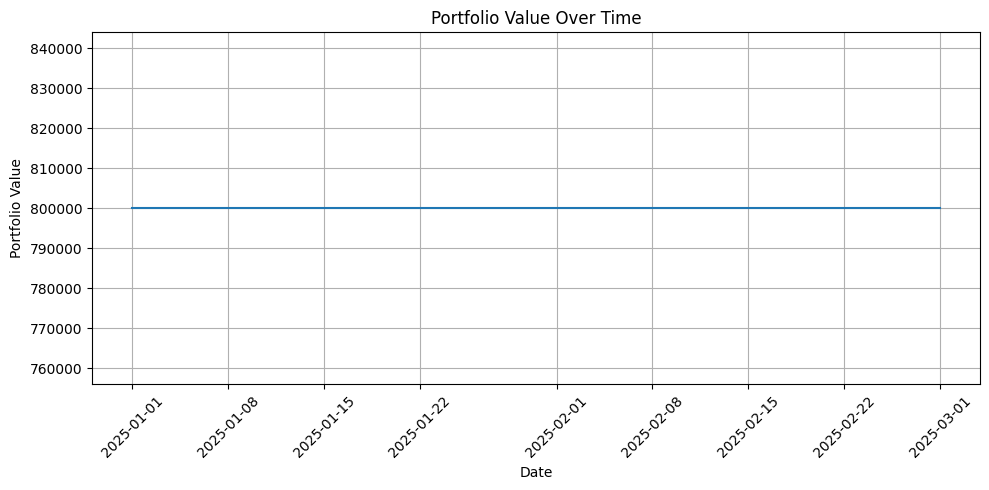

In [56]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()